# Preprocessing: BJH021


This markdown files loads the clean data and does a bipolar rereference as well as epochs the data


In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [13]:
%matplotlib qt5

In [2]:
## Prep paths ##

subject = 'BJH021'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Data ##

# load filtered data #
filtered_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif")

# load raw data #
raw_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif")



Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg-1.fif...
    Range : 2086000 ... 3156499 =   1043.000 ...  1578.249 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg-1.fif...
    Range : 2086000 ... 3156499 =   1043.000 ...  1578.249 secs
Ready.


## Bipolar Rereferencing

In [5]:
filtered_clean_fif

<Raw | BJH021_notched_filtered_clean_ieeg.fif, 257 x 3156500 (1578.2 s), ~258 kB, data not loaded>

In [6]:
# helper functions

def probe_and_num(elec_str): 
    ''' This convenience function takes an electrode string like LHH1 and outputs ('LHH', 1)
    '''
    if '_' in elec_str:
        return None, None
    else:   
        regex_str = '(\D+)(\d+)' # group of letters followed by group of digits
        matcher = re.compile(regex_str,re.IGNORECASE|re.DOTALL).search(elec_str)
        if matcher:
            probe, num = matcher.groups()
            return probe, int(num)
        else:
            return None, None
    
def find_bipolar_pair(ch, labels, remove):
    ''' Find the pair of a given electrode for bipolar referencing.
        Given a single *ch* and a list of *labels*, some of which you want to *remove*,
        this finds the next channel on that probe that isn't meant to be removed (WM is ok).
    '''
    bipolar_pair = None
    probe, num = probe_and_num(ch)
    other_in_probe = [other_ch for other_ch in labels if probe_and_num(other_ch)[0]==probe]
    for i in range(len(other_in_probe)-num):
        next_ch = probe + str(num+i+1)
        if next_ch in remove or next_ch == 'STI':
            continue
        else:
            bipolar_pair = next_ch
            break
    return bipolar_pair

In [7]:
# Here I iterate through the electrodes in my ROIs and match them up with their bipolar pair
pairs = []
anode = []
cathode = []
pairs_name = []
pairs_map = {}
remove = filtered_clean_fif.info['bads']
labels = filtered_clean_fif.info['ch_names']
for ch in labels:
    # if a channel is meant to be removed, it doesn't get to be in a bipolar pair
    if ch in remove or ch == 'STI':
        print(f"{ch} noref")
    else:
        pair = find_bipolar_pair(ch, labels, remove)
        if pair:
            anode.append(ch)
            cathode.append(pair)
            pairs.append((ch, pair))
            pairs_map[ch] = f"{ch}-{pair}"
            pairs_name.append(f"{ch}-{pair}")
            print(ch, pair)

A1 A2
A2 A3
A3 A4
A4 A5
REF1 noref
REF2 noref
A5 A6
A6 A7
A7 A8
A8 A9
A9 A10
A10 A11
A11 A12
A12 A13
A13 A14
A14 A15
A15 A16
B1 noref
B2 noref
B3 B4
B4 B5
B5 B6
B6 B7
B7 B8
B8 B9
B9 B10
B10 B11
B11 B12
B12 B13
B13 B14
C1 noref
C2 noref
C3 noref
C4 noref
C5 C6
C6 C7
C7 C8
C8 C9
C9 C10
C10 C11
C11 C12
C12 C13
C13 C14
D1 D2
D2 D3
D3 D4
D4 D5
D5 D6
D6 D7
D7 D8
D8 D9
D9 D10
D10 D11
D11 D12
D12 D13
D13 D14
E1 E2
E2 E3
E3 E4
E4 E5
E5 E6
E6 E7
E7 E9
E8 noref
E9 E10
F1 F2
F2 F3
F3 F4
F4 F5
F5 F6
F6 F7
F7 F8
F8 F9
F9 F10
F10 F11
F11 F12
G1 G2
G2 G3
G3 G4
G4 G5
G5 G6
G6 G7
G7 G8
G8 G9
G9 G10
G10 G11
G11 G12
G12 G13
G13 G14
H1 H2
H2 H3
H3 H4
H4 H5
H5 H6
H6 H7
H7 H8
H8 H9
H9 H10
H10 H11
H11 H12
H12 H13
H13 H14
H14 H15
H15 H16
I1 I2
I2 I3
I3 I4
I4 I5
I5 I6
I6 I7
I7 I8
I8 I9
I9 I10
I10 I11
I11 I12
J1 J2
J2 J3
J3 J4
J4 J5
J5 J6
J6 J7
J7 J8
J8 J9
J9 J10
J10 J11
J11 J12
J12 J13
J13 J14
K1 K2
K2 K3
K3 K4
K4 K5
K5 K6
K6 K7
K7 K8
K8 K9
K9 K10
K10 K11
K11 K12
K12 K13
K13 K14
K14 K15
K15 K16
L1 L2
L2 L3
L3 L

In [8]:
## Apply Rereference #

if filtered_clean_fif.info['ch_names'] == raw_clean_fif.info['ch_names'] and filtered_clean_fif.info['bads'] == raw_clean_fif.info['bads']:
    
    # load filtered data
    filtered_clean_fif.load_data()
    
    # set filtered reference 
    bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)
    
    # clear var
    bp_filt_fif = []
    filtered_clean_fif = []
    
    # load raw data
    raw_clean_fif.load_data()
    
    # set raw reference 
    bp_raw_fif = mne.set_bipolar_reference(raw_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)

    
    # clear var
    bp_raw_fif = []
    raw_clean_fif = []    
    
    

Reading 0 ... 3156499  =      0.000 ...  1578.249 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=202, n_times=3156500
    Range : 0 ... 3156499 =      0.000 ...  1578.249 secs
Ready.
Added the following bipolar channels:
A1-A2, A2-A3, A3-A4, A4-A5, A5-A6, A6-A7, A7-A8, A8-A9, A9-A10, A10-A11, A11-A12, A12-A13, A13-A14, A14-A15, A15-A16, B3-B4, B4-B5, B5-B6, B6-B7, B7-B8, B8-B9, B9-B10, B10-B11, B11-B12, B12-B13, B13-B14, C5-C6, C6-C7, C7-C8, C8-C9, C9-C10, C10-C11, C11-C12, C12-C13, C13-C14, D1-D2, D2-D3, D3-D4, D4-D5, D5-D6, D6-D7, D7-D8, D8-D9, D9-D10, D10-D11, D11-D12, D12-D13, D13-D14, E1-E2, E2-E3, E3-E4, E4-E5, E5-E6, E6-E7, E7-E9, E9-E10, F1-F2, F2-F3, F3-F4, F4-F5, F5-F6, F6-F7, F7-F8, F8-F9, F9-F10, F10-F11, F11-F12, G1-G2, G2-G3, G3-G4, G4-G5, G5-G6, G6-G7, G7-G8, G8-G9, G9-G10, G10-G11, G11-G12, G12-G13, G13-G14, H1-H2, H2-H3, H3-H4, H4-H5, H5-H6, H6-H7, H7-H8, H8-H9, H9-H10, H10-H11, H11-H12, H12-H13, H13-H14, H14-H15, 

/tmp/ipykernel_3788/1336304392.py:12: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_filtered_clean_data.fif
[done]
Reading 0 ... 3156499  =      0.000 ...  1578.249 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=202, n_times=3156500
    Range : 0 ... 3156499 =      0.000 ...  1578.249 secs
Ready.
Added the following bipolar channels:
A1-A2, A2-A3, A3-A4, A4-A5, A5-A6, A6-A7, A7-A8, A8-A9, A9-A10, A10-A11, A11-A12, A12-A13, A13-A14, A14-A15, A15-A16, B3-B4, B4-B5, B5-B6, B6-B7, B7-B8, B8-B9, B9-B10, B10-B11, B11-B12, B12-B13, B13-B14, C5-C6, C6-C7, C7-C8, C8-C9, C9-C10, C10-C11, C11-C12, C12-C13, C13-C14, D1-D2, D2-D3, D3-D4, D4-D5, D5-D6, D6-D7, D7-D8, D8-D9, D9-D10, D10-D11, D11-D12, D12-D13, D13-D14, E1-E2, E2-E3, E3-E4, E4-E5, E5-E6, E6-E7, E7-E

/tmp/ipykernel_3788/1336304392.py:25: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif
[done]


Opening raw-browser...


libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


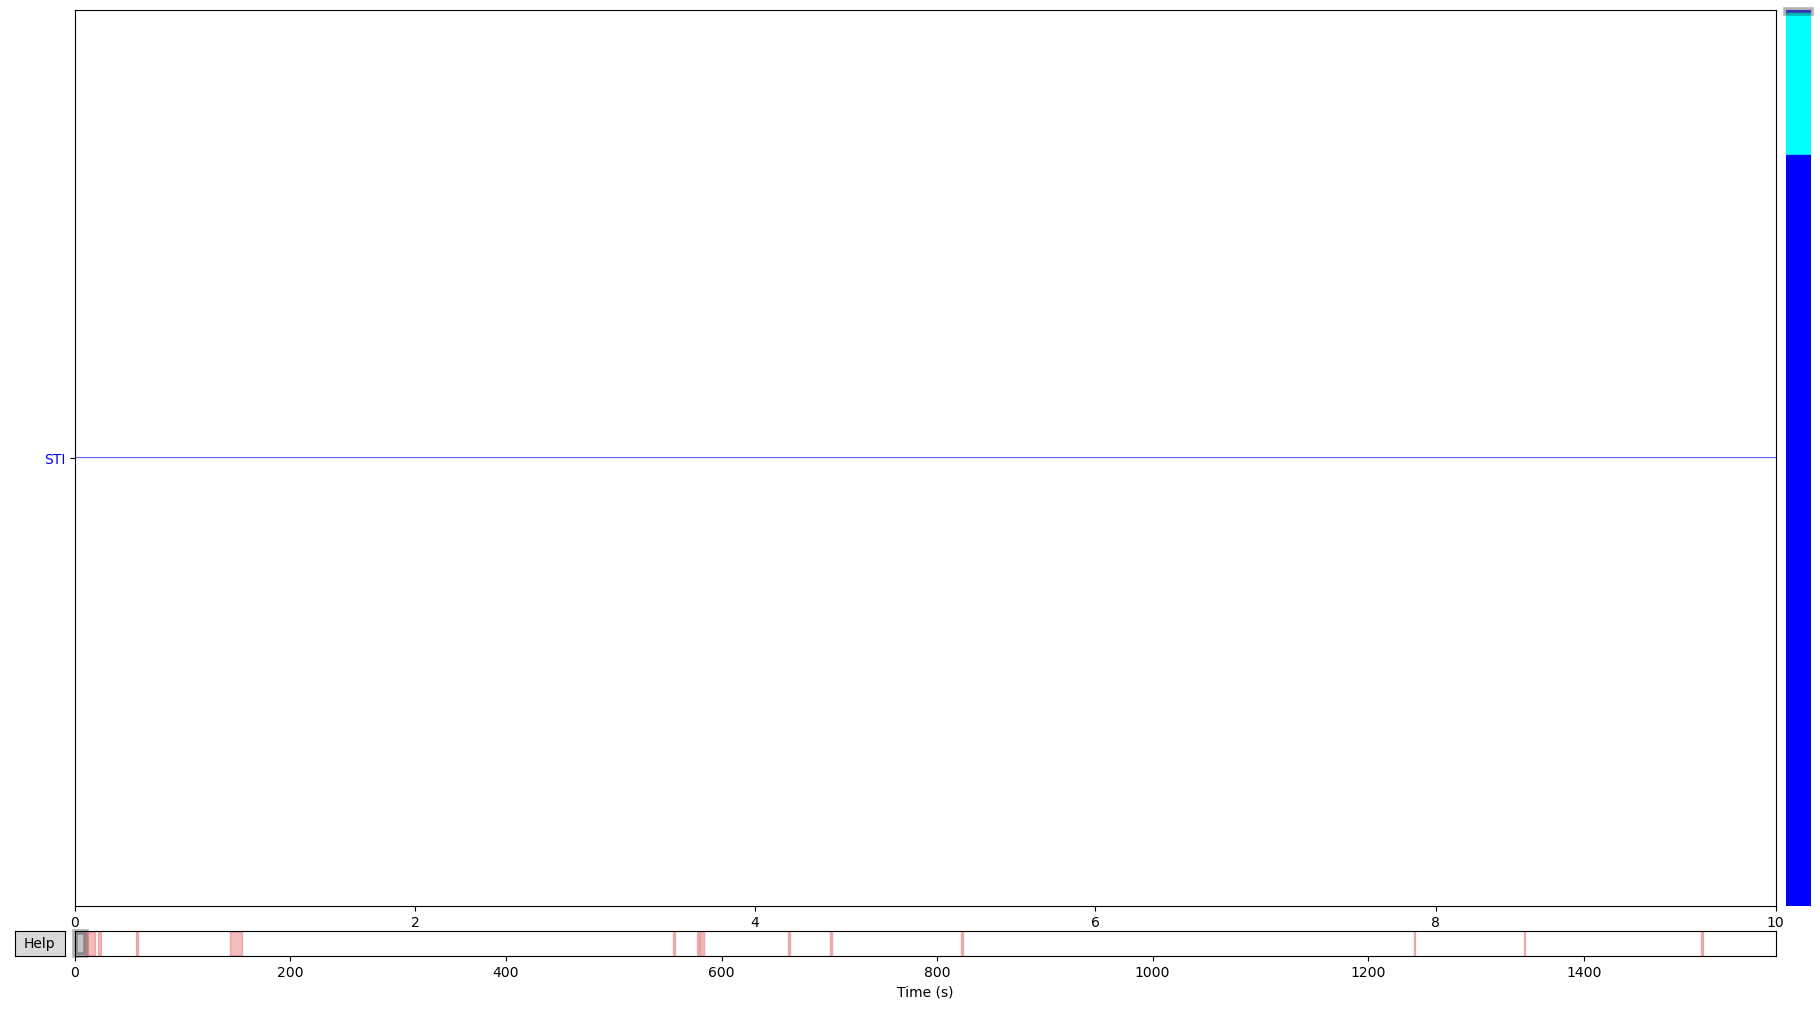

Closing raw-browser...
Channels marked as bad:
['B1', 'B2', 'C1', 'C2', 'C3', 'C4', 'E8', 'EKG1', 'EKG2', 'EMPTY', 'EMPTY_230', 'EMPTY_231', 'O1', 'REF1', 'REF2', 'c3', 'c4', 'cz', 'f10', 'f3', 'f4', 'f7', 'f8', 'f9', 'fp1', 'fp2', 'fpz', 'fz', 'o1', 'o2', 'oz', 'p3', 'p4', 'p7', 'p8', 'pz', 't7', 't8']


In [14]:
# Visualize it #

bp_raw_fif.plot(events=events, color='b', bad_color = 'cyan', n_channels = 1, clipping = None, event_color = 'r')

## Epoching the data 

In [10]:
## Epoching the raw data ##

# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_raw_fif, events, 
                          event_id = 1, tmin = -4, tmax = 12, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif...
    Range : 0 ... 2225999 =      0.000 ...  1112.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data-1.fif...
    Range : 2226000 ... 3156499 =   1113.000 ...  1578.249 secs
Ready.


/tmp/ipykernel_3788/981813422.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")


480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 32001 original time points ...


/tmp/ipykernel_3788/981813422.py:18: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


0 bad epochs dropped
Loading data for 1 events and 32001 original time points ...
Splitting into 4 parts
Loading data for 60 events and 32001 original time points ...
Loading data for 60 events and 32001 original time points ...
Loading data for 60 events and 32001 original time points ...
Loading data for 60 events and 32001 original time points ...


## Trial End

In [3]:
## Epoching the raw data ##

# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_raw_fif, events, 
                          event_id = 0, tmin = -5, tmax = 5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_end-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif...
    Range : 0 ... 2225999 =      0.000 ...  1112.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data-1.fif...
    Range : 2226000 ... 3156499 =   1113.000 ...  1578.249 secs
Ready.


/tmp/ipykernel_155923/4119140940.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")


480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 240 events and 20001 original time points ...


/tmp/ipykernel_155923/4119140940.py:18: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_clean_end-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_end-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


1 bad epochs dropped
Loading data for 1 events and 20001 original time points ...
Splitting into 2 parts
Loading data for 120 events and 20001 original time points ...
Loading data for 119 events and 20001 original time points ...


## Create Other Events

In [ ]:
## Load Behavioral Data ##
last_dot_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_dot_events.csv")
last_dot_data

In [ ]:
# filter to good epochs and fix trial indexing
last_dot_data['trial_numeric'] = last_dot_data['trial_numeric'] - 1

# create events
last_dot_events = last_dot_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [ ]:
# epoch the data
last_dot_epochs = mne.Epochs(bp_raw_fif, last_dot_events, 
                          event_id = 1, tmin = -.75 * 4, tmax =.75 * 3, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
last_dot_epochs.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_dot_events.fif", overwrite = True, split_size = '1.9GB')


Okay, what we need to do is pul the sample of the last dot eaten on each trial

and then also the last turn around

looking for a comparison between these moments on ghost and no ghost trials

we can either get the average and then compare peaks via foof groups in hc and ofc and anterior cingulate

## Last Away

In [3]:
## Load Behavioral Data ##
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")
last_away_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,1,8,46500,0,1
1,4,14,105400,0,1
2,5,2,115600,0,1
3,6,18,132400,0,1
4,7,17,150200,0,1
...,...,...,...,...,...
196,234,19,3000100,0,1
197,235,6,3011100,0,1
198,236,8,3020400,0,1
199,237,13,3028900,0,1


In [4]:
# create events
last_away_events = last_away_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [5]:
# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
last_away_epochs = mne.Epochs(bp_raw_fif, last_away_events, 
                          event_id = 1, tmin = -5, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
last_away_epochs.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif", overwrite = True, split_size = '1.9GB')


Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif...
    Range : 0 ... 2225999 =      0.000 ...  1112.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data-1.fif...
    Range : 2226000 ... 3156499 =   1113.000 ...  1578.249 secs
Ready.
Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Loading data for 201 events and 20001 original time points ...


/tmp/ipykernel_4846/4054492422.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
/tmp/ipykernel_4846/4054492422.py:13: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH021/ieeg/BJH021_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif", overwrite = True, split_size = '1.9GB')


0 bad epochs dropped
Loading data for 1 events and 20001 original time points ...
Splitting into 2 parts
Loading data for 101 events and 20001 original time points ...
Loading data for 100 events and 20001 original time points ...
